## Makemore_MLP_Part3

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
# build the vocab of characters and amppings to/from integers
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i, s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s, i in s2i.items()}
vocab_size = len(i2s)
print(i2s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:

        print(w)
        context = [0] * block_size
        for ch in w + '.':
            idx = s2i[ch]
            X.append(context)
            Y.append(idx)
            print(''.join(i2s[i] for i in context), '-->', i2s[idx])
            context = context[1:] + [idx] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xtst, Ytst = build_dataset(words[n2:]) # 10%

yuheng
... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
diondre
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
xavien
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e
vie --> n
ien --> .
jori
... --> j
..j --> o
.jo --> r
jor --> i
ori --> .
juanluis
... --> j
..j --> u
.ju --> a
jua --> n
uan --> l
anl --> u
nlu --> i
lui --> s
uis --> .
erandi
... --> e
..e --> r
.er --> a
era --> n
ran --> d
and --> i
ndi --> .
phia
... --> p
..p --> h
.ph --> i
phi --> a
hia --> .
samatha
... --> s
..s --> a
.sa --> m
sam --> a
ama --> t
mat --> h
ath --> a
tha --> .
phoenix
... --> p
..p --> h
.ph --> o
pho --> e
hoe --> n
oen --> i
eni --> x
nix --> .
emmelynn
... --> e
..e --> m
.em --> m
emm --> e
mme --> l
mel --> y
ely --> n
lyn --> n
ynn --> .
hollan
... --> h
..h --> o
.ho --> l
hol --> l
oll --> a
lla --> n
lan --> .
hollis
... --> h
..h --> o
.ho --> l
hol --> l
oll --> i
lli --> s
lis --> .
callalily
... --> c
..c --> a
.ca --> l
cal

In [25]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # setting them small to make the initial loss reasonable
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [26]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None # initialization
    loss.backward()

    # update status
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0: # print every once in a while
        print(f'{i: 7d}/{max_steps:7d} : {loss.item(): .4f}')
    lossi.append(loss.log10().item())

    #break

      0/ 200000 :  3.3069
  10000/ 200000 :  2.1900
  20000/ 200000 :  2.2765
  30000/ 200000 :  2.3761
  40000/ 200000 :  1.9500
  50000/ 200000 :  2.5099
  60000/ 200000 :  2.3924
  70000/ 200000 :  2.0238
  80000/ 200000 :  2.2985
  90000/ 200000 :  2.1121
 100000/ 200000 :  1.9558
 110000/ 200000 :  2.1756
 120000/ 200000 :  1.9641
 130000/ 200000 :  2.4462
 140000/ 200000 :  2.3663
 150000/ 200000 :  2.2296
 160000/ 200000 :  1.8477
 170000/ 200000 :  1.8283
 180000/ 200000 :  1.9901
 190000/ 200000 :  1.8223


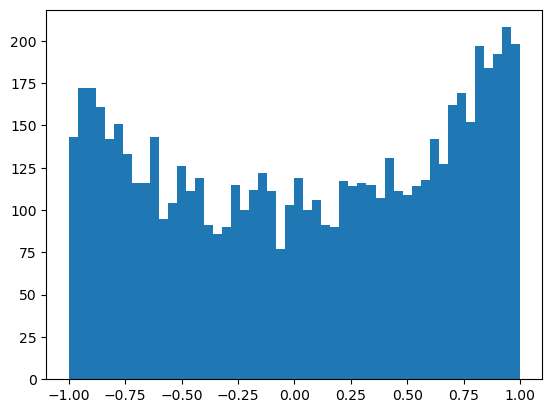

In [23]:
plt.hist(h.view(-1).tolist(), 50); # with smaller b1 and w1, the activation function of h now distribute more normal

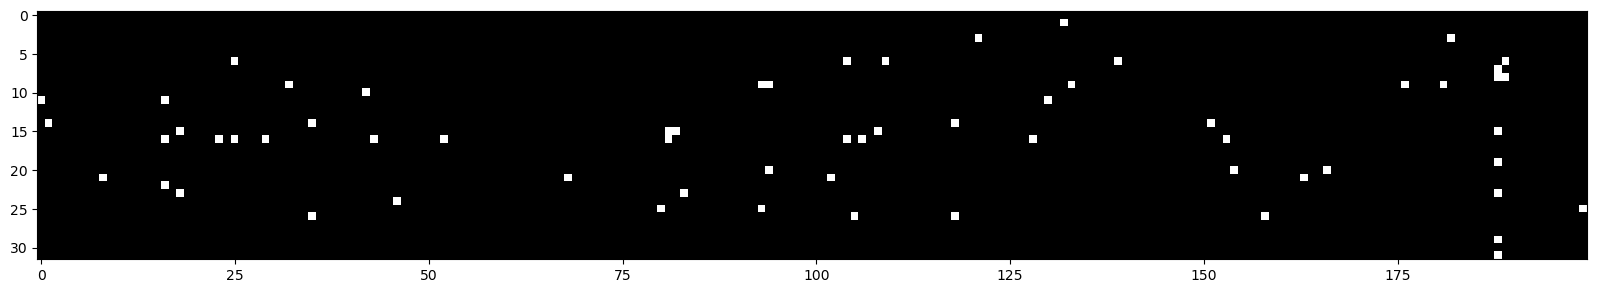

In [24]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # no neuron saturated around 0.99

In [14]:
# fixing the initial loss
# assume all characters should have same probability initially
-torch.tensor(1/27.0).log() # much lower than the previous one 

# so it is best to come up with a better initial loss than current one (24.00) to facilitate the training

tensor(3.2958)

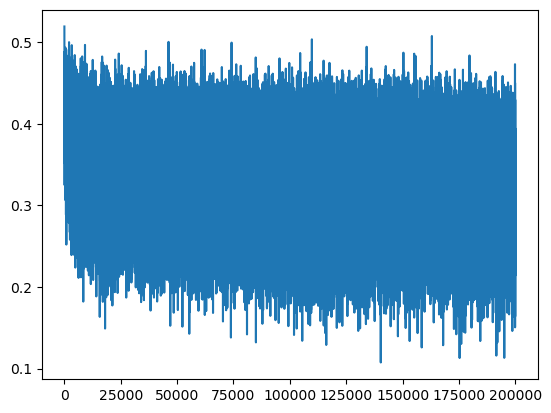

In [27]:
plt.plot(lossi)

In [28]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': {Xtst, Ytst},
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.100118637084961
val 2.1360645294189453


In [ ]:
# loss log

# original:
train 2.231044292449951
val 2.2503163814544678

# fix tanh layer too saturated at init:
train 2.100118637084961
val 2.1360645294189453

# much deeper layer mlp will get more complicated scenarios, bad initial will end with bad results, less forgivable

# batch normalization
train 2.089024543762207
val 2.125288486480713

In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distrubtion
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [idx]
        out.append(idx)
        # if we sample the special '.' token, break
        if idx == 0:
            break
    
    print(''.join(i2s[i] for i in out)) # decode and print the generated word

carlah.
amorilli.
kemri.
rehty.
salaysa.
jazhutefaresartinaqui.
nellara.
chaiir.
kaleig.
dham.
jorn.
quint.
sroel.
alian.
quinaelon.
jarynix.
kaeliigsat.
edde.
oia.
gtan.


tensor(-0.0038) tensor(1.0088)
tensor(-0.0040) tensor(0.9905)


(array([2.25406911e-05, 4.50813822e-05, 2.25406911e-05, 1.12703456e-04,
        1.35244147e-04, 3.38110367e-04, 6.53680042e-04, 7.66383498e-04,
        1.48768561e-03, 2.20898773e-03, 3.69667334e-03, 6.53680042e-03,
        9.91790409e-03, 1.53952920e-02, 2.47496788e-02, 4.04830812e-02,
        6.11078136e-02, 8.94189216e-02, 1.27399986e-01, 1.75096089e-01,
        2.29960131e-01, 2.93795368e-01, 3.51995432e-01, 3.99511209e-01,
        4.26605120e-01, 4.20135942e-01, 4.00525540e-01, 3.45391010e-01,
        2.92803578e-01, 2.30749055e-01, 1.75794850e-01, 1.24379534e-01,
        8.78861547e-02, 6.10627322e-02, 3.98970233e-02, 2.61246610e-02,
        1.64772452e-02, 1.02785551e-02, 6.28885282e-03, 3.56142920e-03,
        2.07374358e-03, 1.23973801e-03, 7.88924189e-04, 5.40976587e-04,
        3.15569676e-04, 1.57784838e-04, 6.76220733e-05, 2.25406911e-05,
        4.50813822e-05, 6.76220733e-05]),
 array([-5.54764414e+00, -5.32582308e+00, -5.10400202e+00, -4.88218096e+00,
        -4.6603599

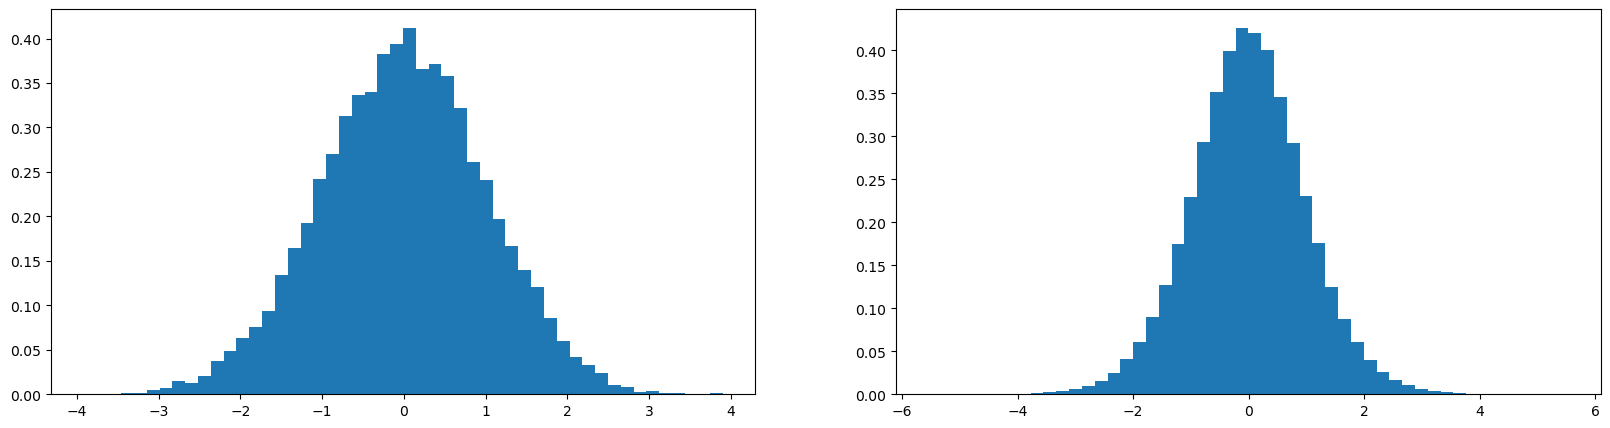

In [30]:
# principle ways to set the scale for initialization more rational
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [ ]:
# observation for the above histogram
# x is a normal distribution, once we multiple with W: y has the similar mean but std expanded, gaussian distribution expanded
# but we want neural to have similar not spreaded activation
# if we increase W, y spread more; if we scale W down, gaussian distribution is shrinking 
# how we scale W? w = torch.randn(10, 200) / 10**0.5
# Delving Deep into Rectifi

In [ ]:
# now there are more approaches made it less important for initialization neuron
# we usually just do torch.nn.init.kaiming_normal
# batch normalization: accerlerating deep network Training by 

In [39]:
# introduce batch normalization

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # setting them small to make the initial loss reasonable
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [40]:
#
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # we try to make hpreact guassian before enter activation func
    hpreact_norm = (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True)
    # result won't be good because we don't want gaussian to stay in hidden layer, only in initialization
    # we introduce scale and shift
    hpreact_norm = hpreact_norm * bngain + bnbias
    
    h = torch.tanh(hpreact_norm) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None # initialization
    loss.backward()

    # update status
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0: # print every once in a while
        print(f'{i: 7d}/{max_steps:7d} : {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000 :  3.3147
  10000/ 200000 :  2.0957
  20000/ 200000 :  2.2439
  30000/ 200000 :  2.3335
  40000/ 200000 :  1.9872
  50000/ 200000 :  2.3823
  60000/ 200000 :  2.4193
  70000/ 200000 :  2.0253
  80000/ 200000 :  2.3451
  90000/ 200000 :  2.0297
 100000/ 200000 :  1.9253
 110000/ 200000 :  2.3152
 120000/ 200000 :  1.9849
 130000/ 200000 :  2.5367
 140000/ 200000 :  2.3879
 150000/ 200000 :  2.2215
 160000/ 200000 :  1.9300
 170000/ 200000 :  1.8929
 180000/ 200000 :  2.0718
 190000/ 200000 :  1.8624


In [41]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [42]:
# use it in last step
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': {Xtst, Ytst},
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.6321029663085938
val 2.64194655418396


In [ ]:
# instead of calculating the bnmean/bnstd in the last step
# we can also apply it on the run
# here is the implementation

In [43]:
# introduce batch normalization
# get bnmean/bnstd in the run

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # setting them small to make the initial loss reasonable
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation, no need since we have bnbias
    # we try to make hpreact guassian before enter activation func
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact_norm = bngain* (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + bnmeani * 0.001
        bnstd_running = 0.999 * bnstd_running + bnstdi * 0.001
    
    h = torch.tanh(hpreact_norm) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None # initialization
    loss.backward()

    # update status
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0: # print every once in a while
        print(f'{i: 7d}/{max_steps:7d} : {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000 :  3.3147
  10000/ 200000 :  2.1471
  20000/ 200000 :  2.2034
  30000/ 200000 :  2.3922
  40000/ 200000 :  1.9677
  50000/ 200000 :  2.4165
  60000/ 200000 :  2.4638
  70000/ 200000 :  1.9695
  80000/ 200000 :  2.3119
  90000/ 200000 :  2.0257
 100000/ 200000 :  1.9442
 110000/ 200000 :  2.1969
 120000/ 200000 :  1.9292
 130000/ 200000 :  2.5179
 140000/ 200000 :  2.3602
 150000/ 200000 :  2.2238
 160000/ 200000 :  1.9746
 170000/ 200000 :  1.8611
 180000/ 200000 :  2.0821
 190000/ 200000 :  1.8968


In [46]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': {Xtst, Ytst},
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.089024543762207
val 2.125288486480713


In [ ]:
# rearrange code to summarize batch normalization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation, no need since we have bnbias
    # BatchNorm layer
    # --------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact_norm = bngain* (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + bnmeani * 0.001
        bnstd_running = 0.999 * bnstd_running + bnstdi * 0.001
    # ----------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact_norm) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None # initialization
    loss.backward()

    # update status
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0: # print every once in a while
        print(f'{i: 7d}/{max_steps:7d} : {loss.item(): .4f}')
    lossi.append(loss.log10().item())

In [ ]:
# reference to read: resnet pytorch, image classification network
# conv1, batchnorm1d
# torch.nn.BatchNorm1d(num_features, eps=1e-5, momentum=0.1, affline=True, track_running_stats=True, device=)

# Summary
# roughly gaussian throughout the neuron network

In [75]:
# SUMMARY ---------
# Let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out),generator=g) / fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),        generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),   
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layer: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # boost by the gain if changed in batchnorm, will still affect the learning

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of para in total
for p in parameters:
    p.requires_grad = True

47551


In [76]:
# optimazation same as before
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None # initialization
    loss.backward()

    # update status
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0: # print every once in a while
        print(f'{i: 7d}/{max_steps:7d} : {loss.item(): .4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
    

      0/ 200000 :  3.2871


layer 2 (      Tanh): mean +0.00, std 0.65, saturated: 2.12%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 1.47%
layer 8 (      Tanh): mean +0.01, std 0.68, saturated: 0.41%
layer 11 (      Tanh): mean -0.00, std 0.68, saturated: 0.16%
layer 14 (      Tanh): mean +0.00, std 0.68, saturated: 0.09%


Text(0.5, 1.0, 'activation distribution')

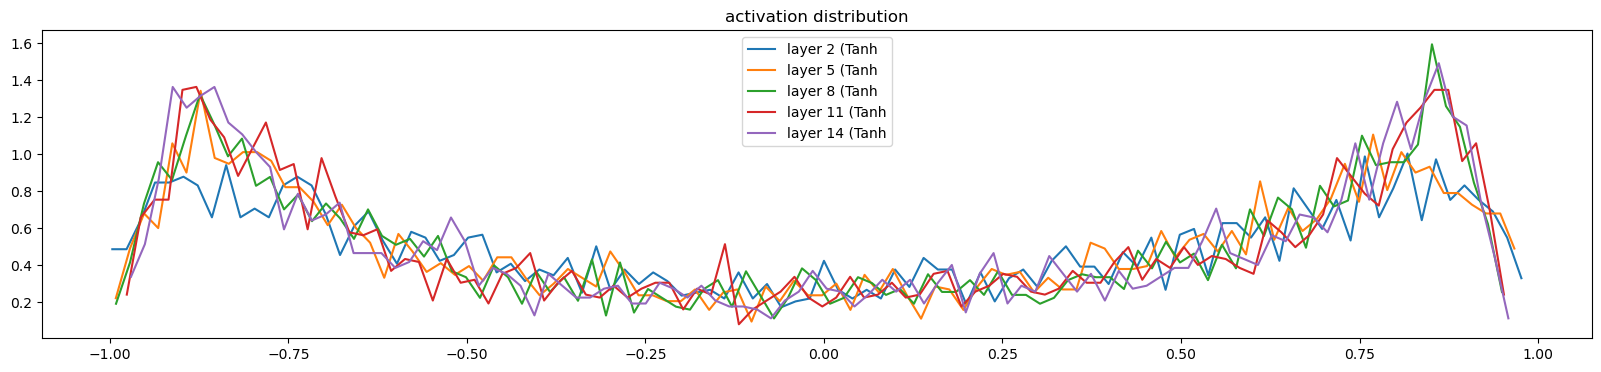

In [77]:
# Visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%'%(
            i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100)
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 9.736128e-04
layer 5 (      Tanh): mean +0.000000, std 7.436912e-04
layer 8 (      Tanh): mean +0.000000, std 6.181914e-04
layer 11 (      Tanh): mean +0.000000, std 6.337874e-04
layer 14 (      Tanh): mean +0.000000, std 8.017434e-04


Text(0.5, 1.0, 'gradient distribution')

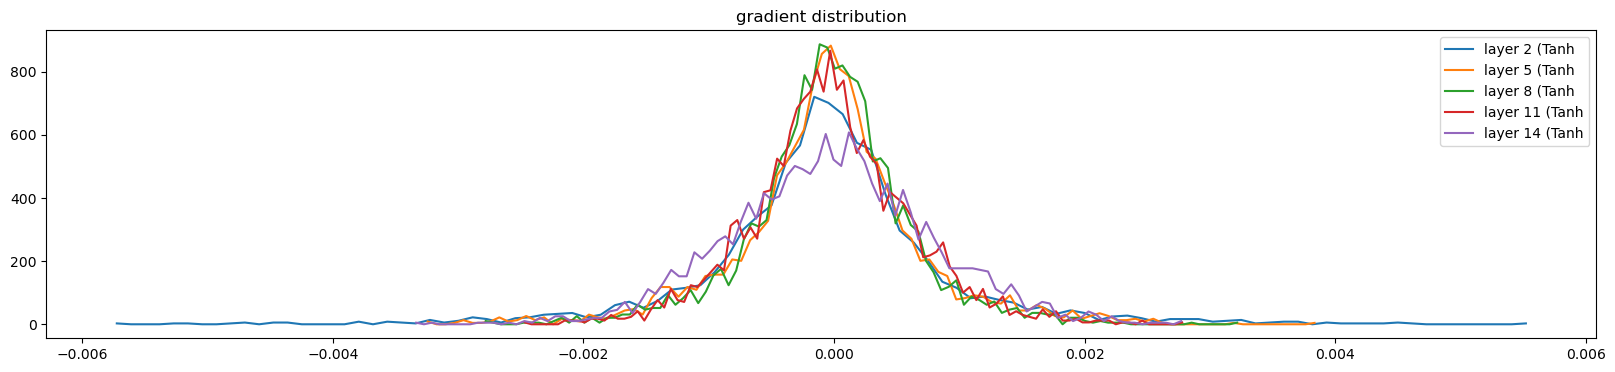

In [78]:
# visualize histogram
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e'%(
            i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')
    

weight   (27, 10)| mean +0.00 | std 6.444091e-03 | grad:data ratio 6.438212e-03
weight  (30, 100)| mean +0.00 | std 1.222042e-02 | grad:data ratio 2.509329e-01
weight (100, 100)| mean +0.00 | std 4.756629e-03 | grad:data ratio 2.388500e-01
weight (100, 100)| mean -0.00 | std 3.982148e-03 | grad:data ratio 2.307609e-01
weight (100, 100)| mean -0.00 | std 3.678562e-03 | grad:data ratio 2.233963e-01
weight (100, 100)| mean -0.00 | std 3.844243e-03 | grad:data ratio 2.297113e-01
weight  (100, 27)| mean +0.00 | std 1.035200e-02 | grad:data ratio 2.920069e-01


Text(0.5, 1.0, 'weights gradient distribution')

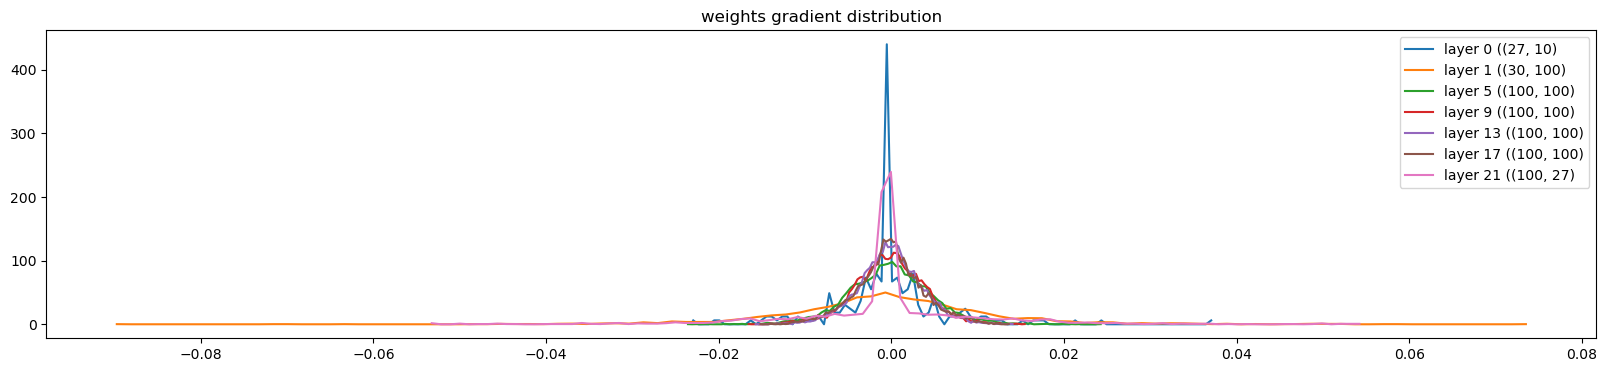

In [79]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters): # note: exclude the output layer
    t = p.grad
    if p.ndim == 2: # 2d parameters
        print('weight %10s| mean %+.2f | std %e | grad:data ratio %e'%(
            tuple(p.shape), t.mean(), t.std(), t.std()/p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')
# we don't want grad/data ratio to be too large
# the last layer is different

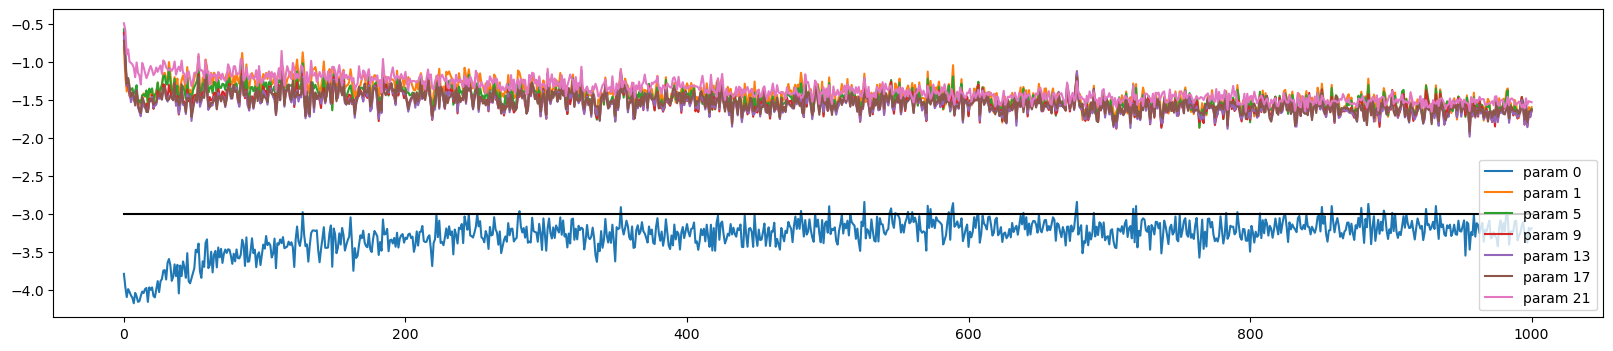

In [80]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be 1e-3, indicate on plot
plt.legend(legends);